http://karpathy.github.io/neuralnets/

In [3]:
# Setup imports

import random
import math
import matplotlib.pyplot as plt

# Backprop

## Random Local Search

In [62]:
def forwardMultiplyGate(x,y):
    return x*y

x = -2; y = 3

tweak = 0.01
best_out = -float('inf')
best_x = x
best_y = y

count = 0
while (count < 100):
    x_try = x + tweak * (random.random() * 2 - 1)
    y_try = y + tweak * (random.random() * 2 - 1)
    score = forwardMultiplyGate(x_try, y_try)
    if score > best_out:
        best_out = score
        best_x = x_try
        best_y = y_try
    count+=1

print(best_out, best_x, best_y)

## Numerical Gradient

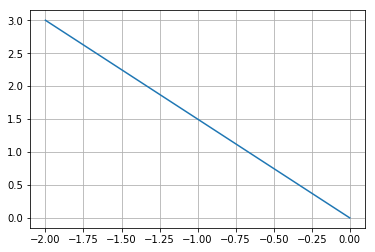

In [79]:
# plt.plot(-2,3, '-')
plt.plot([0,-2], [0,3])
plt.grid(True, which='both')
plt.show()

Imagine taking the output value that comes out from the circuit and tugging on it in the positive direction.
The tugging forces turn out to be the derivative of the output value with respect to its inputs (x and y).

**The derivative can be thought of as a force on each input as we pull on the output to become higher.**

$$ \frac{\partial f(x,y)}{\partial x} = \frac{f(x+h,y) - f(x,y)}{h} $$

In [86]:
x,y = -2,3
out = forwardMultiplyGate(x, y)
h = 0.0001

# compute derivative with respect to x
xph = x + h # -1.9999
out2 = forwardMultiplyGate(xph, y) # -5.9997
x_derivative = (out2 - out) / h # 3.0

# compute derivative with respect to y
yph = y + h # 3.0001
out3 = forwardMultiplyGate(x, yph) # -6.0002
y_derivative = (out3 - out) / h # -2.0

print(x_derivative, y_derivative)

3.00000000000189 -2.0000000000042206


derivative -> a single input  
gradient -> all the inputs (entire circuit)  
The gradient is made up of the derivatives of all the inputs concatenated in a vector (i.e. a list).
Indicates direction of the steepest increase in the function

In [96]:
x,y = -2,3
step_size = 0.01
out = forwardMultiplyGate(x, y) # before: -6
x = x + step_size * x_derivative # x becomes -1.97
y = y + step_size * y_derivative # y becomes 2.98
out_new = forwardMultiplyGate(x, y)
out_new

-5.87059999999986

Need to compute circuit output for every input independently -> linear complexity -> expensive w/ large num of inputs

## Analytic Gradient

$$ \frac{\partial f(x,y)}{\partial x} = \frac{f(x+h,y) - f(x,y)}{h}
= \frac{(x+h)y - xy}{h}
= \frac{xy + hy - xy}{h}
= \frac{hy}{h}
= y $$

note on third step  =>  f(x,y) = xy  
** derivative wrt x is y  
derivative wrt y is x **

In [100]:
x,y = -2,3
x_gradient = y
y_gradient = x
x += step_size * x_gradient
x += step_size * y_gradient
out_new

-5.87059999999986

Gives the exact gradient (via calculus), only requires one forward pass!  Very efficient

## Recursion - circuit w/ multiple gates

New function: $ f(x,y,z) = (x + y) z $

In [103]:
def forwardMultiplyGate(a,b):
    return a*b

def forwardAddGate(a,b):
    return a+b

def forwardCircuit(x,y,z):
    q = forwardAddGate(x,y)
    return forwardMultiplyGate(q,z)

x,y,z = -2, 5, -4
f = forwardCircuit(x,y,z)
f

-12

Calculate the derivatives  
1. multiplication gate: $ f(q,z) = qz \implies q' = z \hspace{0.25in} z' = q $
2. addition gate: $ f(x,y) = x + y \implies x' = 1 \hspace{0.25in} y' = 1 $
3. chain rule: multiply derivatives together (computing gradient of the final output wrt x,y) 
Final derivative for x:  
$$ \frac{\partial f(q,z)}{\partial x} = \frac{\partial q(x,y)}{\partial x} \frac{\partial f(q,z)}{\partial q} $$

In [104]:
x,y,z = -2, 5, -4
q = forwardAddGate(x,y)       #=> 3
f = forwardMultiplyGate(q,z)  #=> -12

# derivatives of multiply gate
derivative_f_wrt_q = z  #=> -4
derivative_f_wrt_z = q  #=> 3

# derivatives of add gate
derivative_q_wrt_x = 1
derivative_q_wrt_y = 1

# chain rule
derivative_f_wrt_x = derivative_q_wrt_x * derivative_f_wrt_q  #=> -4
derivative_f_wrt_y = derivative_q_wrt_y * derivative_f_wrt_q  #=> -4

In [105]:
# final gradient, from above: [-4, -4, 3]
gradient_f_wrt_xyz = [derivative_f_wrt_x, derivative_f_wrt_y, derivative_f_wrt_z]

step_size = 0.01

# let inputs respond to the 'tug' of the gradient
x += step_size * derivative_f_wrt_x  #=> -2.04, pulled down -.04
y += step_size * derivative_f_wrt_y  #=> 4.96, pulled down -.04
z += step_size * derivative_f_wrt_z  #=> -3.97, pulled up +.03

# forward pass w/ new inputs
q = forwardAddGate(x,y)
f = forwardMultiplyGate(q,z)
f

-11.5924

The local derivative of the forwardAddGate (q) is calculated as +1 (how to make value of q higher)  
The gradient on q is calculated as -4, the circuit wants q to decrease by a magnitude of 4
Accordingly, the chain rule applies the gradient according to the full circuit (+1 x -4 = -4)  
**This is how backpropagation works**

> As we pull on the circuit’s output value at the end, this induces pulls downward through the entire circuit, all the way down to the inputs.

## Single Neuron example

$$ f(x,y,a,b,c) = \sigma(ax + by + c) $$

$\sigma$ = sigmoid (squashing function between 0 and 1

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

derivative wrt x:  $$ \frac{\partial \sigma(x)}{\partial x} = \sigma(x) (1 - \sigma(x)) $$

In [189]:
# input to sigmoid gate
x = 3

#forward
f = 1.0 / (1.0 + math.exp(-x)) #=> 0.95

#backprop (gradient)
dx = f * (1.0-f) #=> .045

# note: sigmoid is really a series of gates (division, addition, exponentiation)

In [18]:
class Unit:
    def __init__(self, value, grad):
        # value computed in forward pass
        self.value = value
        # derivative of circuit output wrt this unit; computed in backward pass
        self.grad = grad

In [19]:
class multiplyGate:
    def forward(self, u0, u1):
        self.u0 = u0
        self.u1 = u1
        # backprop is auto initialized to 0.0
        self.utop = Unit(self.u0.value * self.u1.value, 0.0)
        return self.utop
    
    def backward(self):
        # gradient in output unit chained with local gradients
        self.u0.grad += self.u1.value * self.utop.grad
        self.u1.grad += self.u0.value * self.utop.grad

In [20]:
class addGate:
    def forward(self, u0, u1):
        self.u0 = u0
        self.u1 = u1
        self.utop = Unit(self.u0.value + self.u1.value, 0.0)
        return self.utop
    
    def backward(self):
        self.u0.grad += 1 * self.utop.grad
        self.u1.grad += 1 * self.utop.grad

In [21]:
class sigmoidGate:
    def sig(self, x):
        return 1 / (1 + math.exp(-x))
    
    # only takes one input
    def forward(self, u0):
        self.u0 = u0
        self.utop = Unit(self.sig(self.u0.value), 0.0)
        return self.utop
    
    def backward(self):
        s = self.sig(self.u0.value);
        self.u0.grad += (s * (1.0 - s)) * self.utop.grad

In [22]:
# create inputs
a = Unit(1.0, 0.0)
b = Unit(2.0, 0.0)
c = Unit(-3.0, 0.0)
x = Unit(-1.0, 0.0)
y = Unit(3.0, 0.0)

# create gates
mulg0 = multiplyGate()
mulg1 = multiplyGate()
addg0 = addGate()
addg1 = addGate()
sg = sigmoidGate()

# forward pass
def forwardNeuron():
    ax = mulg0.forward(a,x)
    by = mulg1.forward(b,y)
    axpby = addg0.forward(ax,by)
    axpbypc = addg1.forward(axpby,c)
    return sg.forward(axpbypc)

s = forwardNeuron()
s.value, s.grad

(0.8807970779778823, 0.0)

In [23]:
# to compute the gradient we iterate in reverse and call backward
s.grad = 1.0
# set gradient chain at output to 1.0 to start things off.  Increase value of function

sg.backward()    # writes gradient into axpbypc
addg1.backward() # writes gradient into axpby, c
addg0.backward() # writes gradient into ax, by
mulg1.backward() # writes gradient into b, y
mulg0.backward() # writes gradient into a, x

In [24]:
# make inputs respond to computed gradients
step_size = 0.01;
a.value += step_size * a.grad # a.grad is -0.105
b.value += step_size * b.grad # b.grad is 0.315
c.value += step_size * c.grad # c.grad is 0.105
x.value += step_size * x.grad # x.grad is 0.105
y.value += step_size * y.grad # y.grad is 0.210

print(a.grad, b.grad, c.grad, x.grad, y.grad)

s = forwardNeuron()
s.value

-0.10499358540350662 0.31498075621051985 0.10499358540350662 0.10499358540350662 0.20998717080701323


0.8825501816218984

In [25]:
# check numerical gradient
def forwardCircuitFast(a,b,c,x,y):
    return 1/(1 + math.exp( - (a*x + b*y + c)))

a,b,c,x,y = 1,2,-3,-1,3
h = 0.0001;
a_grad = (forwardCircuitFast(a+h,b,c,x,y) - forwardCircuitFast(a,b,c,x,y))/h;
b_grad = (forwardCircuitFast(a,b+h,c,x,y) - forwardCircuitFast(a,b,c,x,y))/h;
c_grad = (forwardCircuitFast(a,b,c+h,x,y) - forwardCircuitFast(a,b,c,x,y))/h;
x_grad = (forwardCircuitFast(a,b,c,x+h,y) - forwardCircuitFast(a,b,c,x,y))/h;
y_grad = (forwardCircuitFast(a,b,c,x,y+h) - forwardCircuitFast(a,b,c,x,y))/h;

print(a_grad, b_grad, c_grad, x_grad, y_grad)

-0.10499758359205913 0.3149447748351797 0.10498958734506125 0.10498958734506125 0.2099711788272618


In [26]:
# lets do our neuron in two steps:
def sig(x):
    return 1 / (1 + math.exp(-x))

# forward pass
q = a*x + b*y + c;
f = sig(q)

# backward pass; given df:
df = 1
dq = (f * (1.0 - f)) * df
da = x * dq
dx = a * dq
db = y * dq
dy = b * dq
dc = 1 * dq

print (da, db, dc, dx, dy)

-0.10499358540350662 0.31498075621051985 0.10499358540350662 0.10499358540350662 0.20998717080701323


### Gradient examples

In [ ]:
# calculate the gradient of complex function
x = math.pow(((a * b + c) * d), 2) # pow(x,2) squares the input

# split it up into chunks
z = a * b + c
y = z * d
x = y * y

dy = 2 * y * dx
dd = z * dy
dz = d * dy
da = b * dz
db = a * dz
dc = 1 * dz
# done!

# + gate simply takes the gradient on top and routes it equally to all of its inputs
# * gate acts as a switcher during backward pass; 

In [ ]:
# other useful gradients:
# division
x = 1.0/a
da = -1.0/(a*a);

# division in practice
x = (a + b)/(c + d);

# lets decompose it in steps:
y = a + b
z = c + d
q = 1/z
x = y * q

# backprop
dy = q * dx
dq = y * dx
dz = -1(z*z) * dq
dc = 1 * dz
dd = 1 * dz
da = 1 * dy
db = 1 * dy

In [ ]:
# another useful one:
# max gate acts as a simple switch between a or b
x = math.max(a, b);

# if a is the result of max -> a' = 1 else 0
# if b is the result of max -> b' = 1 else 0
da = 1.0 * dx if a == x else 0.0
db = 1.0 * dx if b == x else 0.0
 
# RELU
x = math.max(a, 0)

# backprop through this gate will then be:
da = 1.0 * dx if a > 0 else 0.0

# Machine Learning

## Support Vector Machine

SVM - linear classifier:  $ \hspace{0.25in} f(x,y) = ax + by + c $

#### SVM 'Force Specification'

- If we feed a positive datapoint through the SVM circuit and the output value is less than 1, pull on the circuit with force +1. This is a positive example so we want the score to be higher for it.
- Conversely, if we feed a negative datapoint through the SVM and the output is greater than -1, then the circuit is giving this datapoint dangerously high score: Pull on the circuit downwards with force -1.
- In addition to the pulls above, always add a small amount of pull on the parameters a,b (notice, not on c!) that pulls them towards zero. If a becomes very high it will experience a strong pull of magnitude |a| back towards zero. This pull is something we call *regularization*, and it ensures that neither of our parameters a or b gets disproportionally large.  If either of them is too high, our classifier would be overly sensitive to these features.

#### SVM for binary classification example

In [41]:
# A circuit: it takes 5 Units (x,y,a,b,c) and outputs a single Unit
# It can also compute the gradient w.r.t. its inputs
class Circuit:
    def __init__(self):
        # create some gates
        self.mulg0 = multiplyGate();
        self.mulg1 = multiplyGate();
        self.addg0 = addGate();
        self.addg1 = addGate();

    def forward(self,x,y,a,b,c):
        self.ax = self.mulg0.forward(a, x) # a*x
        self.by = self.mulg1.forward(b, y) # b*y
        self.axpby = self.addg0.forward(self.ax, self.by) # a*x + b*y
        self.axpbypc = self.addg1.forward(self.axpby, c) # a*x + b*y + c
        return self.axpbypc
  
    def backward(self,gradient_top):  # takes pull from above
        self.axpbypc.grad = gradient_top;
        self.addg1.backward() # sets gradient in axpby and c
        self.addg0.backward() # sets gradient in ax and by
        self.mulg1.backward() # sets gradient in b and y
        self.mulg0.backward() # sets gradient in a and x

In [42]:
class SVM:
    def __init__(self):
        # random initial weights
        self.a = Unit(1.0, 0.0);
        self.b = Unit(-2.0, 0.0);
        self.c = Unit(-1.0, 0.0);
        self.circuit = Circuit();

    def forward(self, x, y):  # assume x and y are Units
        self.unit_out = self.circuit.forward(x, y, self.a, self.b, self.c)
        return self.unit_out

    def backward(self, label): # label is +1 or -1
        # reset pulls on a,b,c
        self.a.grad = 0.0;
        self.b.grad = 0.0;
        self.c.grad = 0.0;

        # compute the pull(starting gradient) based on what the circuit output was
        pull = 0.0;
        if(label == 1 and self.unit_out.value < 1):
            pull = 1 # the score was too low: pull up
        if(label == -1 and self.unit_out.value > -1):
            pull = -1 # the score was too high for a positive example, pull down

        self.circuit.backward(pull) # writes gradient into x,y,a,b,c
    
        # add regularization pull for multiplication parameters: towards zero and proportional to value
#         self.a.grad -= self.a.value;
#         self.b.grad -= self.b.value;

    def parameterUpdate(self): # update weights according to backprop
        step_size = 0.01;
        self.a.value += step_size * self.a.grad
        self.b.value += step_size * self.b.grad
        self.c.value += step_size * self.c.grad
        
    def learnFrom(self, x, y, label):
        self.forward(x, y) # forward pass (set .value in all Units)
        self.backward(label) # backward pass (set .grad in all Units)
        self.parameterUpdate() # parameters respond to tug

#### Train w/ SGD

In [43]:
data = [[1.2, 0.7], [-0.3, -0.5], [3.0, 0.1], [-0.1, -1.0], [-1.0, 1.1], [2.1, -3]]
labels = [1, -1, 1, -1, -1, 1]
svm = SVM()

# a function that computes the classification accuracy
def evalTrainingAccuracy():
    num_correct = 0
    for i,d in enumerate(data):
        x = Unit(d[0], 0.0)
        y = Unit(d[1], 0.0)
        true_label = labels[i]

        # see if the prediction matches the provided label
        predicted_label = 1 if svm.forward(x, y).value > 0 else -1
        if predicted_label == true_label:
            num_correct += 1

    return num_correct / len(data)

In [47]:
# the learning loop
for iterator in range(0,400):
    # pick a random data point
    i = math.floor(random.random() * len(data))
    x = Unit(data[i][0], 0.0);
    y = Unit(data[i][1], 0.0);
    label = labels[i];
    svm.learnFrom(x, y, label)

    if iterator % 25 == 0: # every 25 iterations...
        acc = evalTrainingAccuracy()
        print(f"training accuracy at iter {iterator}: {acc}")

training accuracy at iter 0: 1.0
training accuracy at iter 25: 1.0
training accuracy at iter 50: 1.0
training accuracy at iter 75: 1.0
training accuracy at iter 100: 1.0
training accuracy at iter 125: 1.0
training accuracy at iter 150: 1.0
training accuracy at iter 175: 1.0
training accuracy at iter 200: 1.0
training accuracy at iter 225: 1.0
training accuracy at iter 250: 1.0
training accuracy at iter 275: 1.0
training accuracy at iter 300: 1.0
training accuracy at iter 325: 1.0
training accuracy at iter 350: 1.0
training accuracy at iter 375: 1.0


### NOTE:  SVM does not converge on the function with regularization!!

** Convergence does occur w/ regularization in place and smaller pulls for the other two scenarios not handled in the forward pass (i.e. label == 1 and score > 1: pull -0.5) but will not remain steady... ** 

#### Condensed SVM

In [55]:
a,b,c = 1,-2,-1 # initial parameters

for iterator in range(0,400):
    # pick a random data point
    i = math.floor(random.random() * len(data))
    x = data[i][0]
    y = data[i][1]
    label = labels[i]

    # forward pass - compute pull
    score = a*x + b*y + c
    pull = 0.0
    if(label == 1 and score < 1):
        pull = 1
    if(label == 1 and score > 1):
        pull = -0.5
    if(label == -1 and score > -1):
        pull = -1
    if(label == -1 and score > -1):
        pull = .05
        
    # backward pass - compute gradient and update parameters accordingly
    step_size = 0.01;
    a += step_size * (x * pull - a) # -a is from the regularization
    b += step_size * (y * pull - b) # -b is from the regularization
    c += step_size * (1 * pull);
    

    if iterator % 25 == 0: # every 25 iterations... 
        # compute accuracy
        num_correct = 0
        for i,l in zip(data,labels):
            x = i[0]
            y = i[1]
            true_label = l
            
            pred_score = a*x + b*y + c
            # see if the prediction matches the provided label
            predicted = 1 if pred_score > 0 else -1
            if predicted == true_label:
                num_correct += 1
        percent_correct = num_correct / len(data)
        print(f"training accuracy at iter {iterator}: {percent_correct}")

training accuracy at iter 0: 0.6666666666666666
training accuracy at iter 25: 0.6666666666666666
training accuracy at iter 50: 0.6666666666666666
training accuracy at iter 75: 0.8333333333333334
training accuracy at iter 100: 0.8333333333333334
training accuracy at iter 125: 0.8333333333333334
training accuracy at iter 150: 0.8333333333333334
training accuracy at iter 175: 0.8333333333333334
training accuracy at iter 200: 0.8333333333333334
training accuracy at iter 225: 0.8333333333333334
training accuracy at iter 250: 1.0
training accuracy at iter 275: 1.0
training accuracy at iter 300: 1.0
training accuracy at iter 325: 1.0
training accuracy at iter 350: 1.0
training accuracy at iter 375: 1.0


## Generalizing SVM into neural network

In [1]:
# compute accuracy
def computeAccuracy():
    num_correct = 0
    for i,d in enumerate(data):
        x = d[0]
        y = d[1]
        true_label = labels[i]

        # forward pass
        n1 = max(0, a1*x + b1*y + c1); # activation of 1st hidden neuron
        n2 = max(0, a2*x + b2*y + c2); # 2nd neuron
        n3 = max(0, a3*x + b3*y + c3); # 3rd neuron
        pred_score = a4*n1 + b4*n2 + c4*n3 + d4; # the score

        # see if the prediction matches the provided label
        predicted = 1 if pred_score > 0 else -1
        if predicted == true_label:
            num_correct += 1
    return num_correct / len(data)

In [8]:
data = [[1.2, 0.7], [-0.3, -0.5], [3.0, 0.1], [-0.1, -1.0], [-1.0, 1.1], [2.1, -3]]
labels = [1, -1, 1, -1, -1, 1]

# random initial weights
a1 = random.random() - 0.5; # a random number between -0.5 and 0.5
b1 = random.random() - 0.5; # a random number between -0.5 and 0.5
c1 = random.random() - 0.5; # a random number between -0.5 and 0.5
a2 = random.random() - 0.5; # a random number between -0.5 and 0.5
b2 = random.random() - 0.5; # a random number between -0.5 and 0.5
c2 = random.random() - 0.5; # a random number between -0.5 and 0.5
a3 = random.random() - 0.5; # a random number between -0.5 and 0.5
b3 = random.random() - 0.5; # a random number between -0.5 and 0.5
c3 = random.random() - 0.5; # a random number between -0.5 and 0.5
a4 = random.random() - 0.5; # a random number between -0.5 and 0.5
b4 = random.random() - 0.5; # a random number between -0.5 and 0.5
c4 = random.random() - 0.5; # a random number between -0.5 and 0.5
d4 = random.random() - 0.5; # a random number between -0.5 and 0.5

# ... similarly initialize all other parameters to randoms
for iterator in range(0,400):
    # pick a random data point
    i = math.floor(random.random() * len(data));
    x = data[i][0];
    y = data[i][1];
    label = labels[i];

  # forward pass:

    #2 layer neural network w/ 3 hidden neurons
    n1 = max(0, a1*x + b1*y + c1) # activation of 1st hidden neuron
    n2 = max(0, a2*x + b2*y + c2) # 2nd neuron
    n3 = max(0, a3*x + b3*y + c3) # 3rd neuron
    score = a4*n1 + b4*n2 + c4*n3 + d4; # the score

    # compute the pull on top
    pull = 0.0;
    if(label == 1 and score < 1): pull = 1; # we want higher output! Pull up.
    if(label == -1 and score > -1): pull = -1; # we want lower output! Pull down.

        
  # backward pass:

    # backprop through the last "score" neuron
    da4 = n1 * pull;
    dn1 = a4 * pull;
    db4 = n2 * pull;
    dn2 = b4 * pull;
    dc4 = n3 * pull;
    dn3 = c4 * pull;
    dd4 = 1.0 * pull;

    # backprop the ReLU non-linearities, in place
    # i.e. just set gradients to zero if the neurons did not "fire"
    dn3 = 0 if n3 == 0 else dn3;
    dn2 = 0 if n2 == 0 else dn2;
    dn1 = 0 if n1 == 0 else dn1;

    # backprop to parameters of neuron 1
    da1 = x * dn1;
    db1 = y * dn1;
    dc1 = 1.0 * dn1;

    # backprop to parameters of neuron 2
    da2 = x * dn2;
    db2 = y * dn2;
    dc2 = 1.0 * dn2;

    # backprop to parameters of neuron 3
    da3 = x * dn3;
    db3 = y * dn3;
    dc3 = 1.0 * dn3;

    # phew! End of backprop!
    # note we could have also backpropped into x,y
    # but we do not need these gradients. We only use the gradients
    # on our parameters in the parameter update, and we discard x,y

    # add the pulls from the regularization, tugging all multiplicative
    # weights (i.e. not the biases) downward, proportional to their value
#     da1 += -a1; da2 += -a2; da3 += -a3;
#     db1 += -b1; db2 += -b2; db3 += -b3;
#     da4 += -a4; db4 += -b4; dc4 += -c4;

    # finally, do the parameter update
    step_size = 0.01;
    a1 += step_size * da1; 
    b1 += step_size * db1; 
    c1 += step_size * dc1;
    a2 += step_size * da2; 
    b2 += step_size * db2;
    c2 += step_size * dc2;
    a3 += step_size * da3; 
    b3 += step_size * db3; 
    c3 += step_size * dc3;
    a4 += step_size * da4; 
    b4 += step_size * db4; 
    c4 += step_size * dc4; 
    d4 += step_size * dd4;
    # wow this is tedious, please use for loops in prod.
    # we're done!
    
    if iterator % 25 == 0: # every 25 iterations... 
        print(f"training accuracy at iter {iterator}: {computeAccuracy()}")

training accuracy at iter 0: 0.5
training accuracy at iter 25: 0.5
training accuracy at iter 50: 0.5
training accuracy at iter 75: 0.5
training accuracy at iter 100: 0.6666666666666666
training accuracy at iter 125: 0.6666666666666666
training accuracy at iter 150: 0.8333333333333334
training accuracy at iter 175: 1.0
training accuracy at iter 200: 1.0
training accuracy at iter 225: 1.0
training accuracy at iter 250: 1.0
training accuracy at iter 275: 1.0
training accuracy at iter 300: 1.0
training accuracy at iter 325: 1.0
training accuracy at iter 350: 1.0
training accuracy at iter 375: 1.0


## Loss Functions

2-dimensional SVM. We are given a dataset of N examples $(x_{i0},x_{i1})$ and their corresponding labels $y_i$ which are allowed to be either +1/−1 for positive or negative example respectively. Most importantly, as you recall we have three parameters $(w_0,w_1,w_2)$.  The loss function:

$$ L = [\sum_{i=1}^N max(0, -y_{i}( w_0x_{i0} + w_1x_{i1} + w_2 ) + 1 )] + \alpha [w_0^2 + w_1^2] $$

Note: this expression is always positive (thresholding at 0 and squaring in regularization).  Objective is to minimize this function.

In [17]:
X = [ [1.2, 0.7], [-0.3, 0.5], [3, 2.5] ] # array of 2-dimensional data
y = [1, -1, 1] # array of labels
w = [0.1, 0.2, 0.3] # example: random numbers
alpha = 0.1 # regularization strength

# def cost(X, y, w):

total_cost = 0.0; # L, in SVM loss function above

for i,x in enumerate(X):
    # loop over all data points and compute their score
    xi = x
    score = w[0] * xi[0] + w[1] * xi[1] + w[2]

    # accumulate cost based on how compatible the score is with the label
    yi = y[i]; # label
    costi = max(0, - yi * score + 1);
    print(f'example {i}: xi = ({xi}) and label = {yi} -- score computed to be {score:.3f}');
    print(f'  => cost computed to be {costi:.3f}');
    total_cost += costi;

# regularization cost: we want small weights
reg_cost = alpha * (w[0]*w[0] + w[1]*w[1])
print(f'regularization cost for current model is {reg_cost:.3f}');
total_cost += reg_cost;

print(f'total cost is {total_cost:.3f}');

example 0: xi = ([1.2, 0.7]) and label = 1 -- score computed to be 0.560
  => cost computed to be 0.440
example 1: xi = ([-0.3, 0.5]) and label = -1 -- score computed to be 0.370
  => cost computed to be 1.370
example 2: xi = ([3, 2.5]) and label = 1 -- score computed to be 1.100
  => cost computed to be 0.000
regularization cost for current model is 0.005
total cost is 1.815
